## Part 2a) Assigment

In [15]:
import torch
from torch import nn, Tensor
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.io import decode_image
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict, Optional
import time

In [16]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

Using mps device


In [17]:

dataset_paths = ["/Users/leonardomassaro/Desktop/DatasetOxford/", "/scratch.hpc/leomass/"]
correct_path = None

for path in dataset_paths:
    if os.path.exists(path) and os.path.isdir(path):
        print("Detected dataset on ", path)
        correct_path = path
if not correct_path:
    raise Exception("No dataset found")

Detected dataset on  /Users/leonardomassaro/Desktop/DatasetOxford/


In [18]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [19]:
class OxfordPetDataset(Dataset):
    def __init__(self, path, transform=None) -> None:
        super().__init__()

        self.root = Path(path)
        self.transform = transform
        self.names, self.labels = self._get_names_and_labels()
        loaded_data = []
        idx = 0
        while idx < len(self.names):
            name = self.names[idx]
            img_tensor = self.get_img_from_filesystem(name)
            if img_tensor == None:
                self.names.pop(idx)
                self.labels.pop(idx)
                continue
            loaded_data.append(img_tensor)
            idx += 1

        self.data_tensor = torch.stack(loaded_data).to(device=device)
        self.labels = torch.Tensor(self.labels).type(torch.LongTensor).to(device=device)
        
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:

        label = self.labels[idx]
        img = self.data_tensor[idx]

        return img, label
    
    def get_img_from_filesystem(self, name) -> Tensor:
        img_path = self.root / "images" / f"{name}.jpg"
        img = decode_image(img_path).to(torch.float)
        if img == None or img.shape[0] != 3:
            print("Bad channel formatting for image: ", img_path.__str__(), " skipping it...")
            return None

        if self.transform:
            img = self.transform(img)

        return img


    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / "list.txt") as f:
            for line in f:
                if(line[0] == "#"):
                    continue
                name, label, _, _ = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

In [20]:
BATCH_SIZE = 64

transform_stack = transforms.Compose([
    transforms.Resize((256,256))
])

dataset = OxfordPetDataset(correct_path, transform=transform_stack)

train_ds, validation_ds, test_ds = random_split(dataset, [8/10, 0/10, 2/10])

# Create data loaders.
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_ds, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([17, 3, 256, 256])
Shape of y: torch.Size([17]) torch.int64


/opt/homebrew/lib/python3.12/site-packages/torch/utils/data/dataset.py:469: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


In [21]:

# Defining custom Dense Block
class DenseBlock(nn.Module):
    def __init__(self, num_convs:int, num_channels:int, has_transition:bool):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(self.conv_block(num_channels))
        self.dense_net = nn.Sequential(*layer)
        self.transition_net = self.transition_block() if has_transition else None

    def conv_block(self, num_channels):
        return (
            nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.ReLU(),
                nn.LazyConv2d(num_channels, 3, padding=1))
        )
    
    def transition_block(self): #transition block to reduce channel dimensionality (conv has to be 1x1)
        return (
            nn.Sequential(
                nn.LazyBatchNorm2d(),
                nn.ReLU(),
                nn.LazyConv2d(16, 1),
                nn.AdaptiveAvgPool2d((1,1)))
        )

    def forward(self, X):
        # In the Dense block, every layer has in input the concatenation of all the previous ones
        for block in self.dense_net:
            last_out = block(X)
            X = torch.cat((X, last_out), dim=1)
        if self.transition_net != None:
            X = self.transition_net(X)
        return X

In [ ]:

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        stem_block = [ #initial stem block, like resnet
            nn.LazyConv2d(32, 8),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(3),
        ]

        num_dense_blocks = 4
        dense_core = [
            DenseBlock(num_convs=4, num_channels=16, has_transition= True ) for i in range(num_dense_blocks)
        ]

        classification_block = [
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.LazyLinear(37)
        ]

        self.net_stack = nn.Sequential(*stem_block, *dense_core, *classification_block)

    def forward(self, x):
        result = self.net_stack(x)
        return result

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (net_stack): Sequential(
    (0): LazyConv2d(0, 32, kernel_size=(8, 8), stride=(1, 1))
    (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): DenseBlock(
      (dense_net): Sequential(
        (0): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): Sequential(
          (0): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): LazyConv2d(0, 

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [24]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    loss = None
    for (X, y) in dataloader:
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return loss.item()

In [25]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 150

net_performance_data = {
    "train_loss": [],
    "test_loss": [],
    "test_accuracy": []
}

t1 = time.time()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    net_performance_data["train_loss"].append( train(train_dataloader, model, loss_fn, optimizer) )
    test_accuracy, test_loss = test(test_dataloader, model, loss_fn)
    net_performance_data["test_loss"].append( test_loss )
    net_performance_data["test_accuracy"].append( test_accuracy )

t2 = time.time()

print("Done in ", t2-t1, " sec")

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------


KeyboardInterrupt: 

<Axes: >

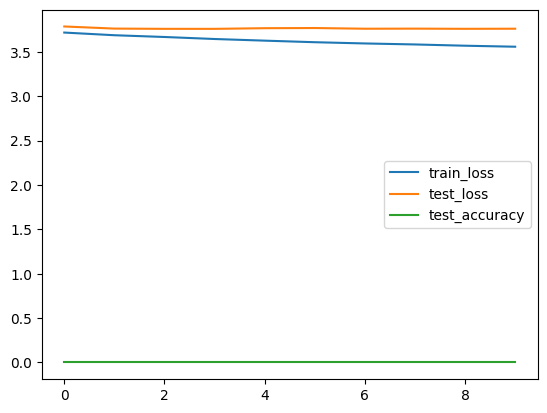

In [ ]:
net_performance_data_df = pd.DataFrame(data=net_performance_data)

net_performance_data_df.plot()